In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2,Xception
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [0]:
INIT_LR = 1e-4
EPOCHS = 4
BS = 32

In [0]:
imagePaths = list(paths.list_images("drive/My Drive/Dataset"))
data = []
labels = []

In [0]:
for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    data.append(image)
    labels.append(label)

In [10]:
len(data)

1484

In [0]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [0]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [0]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [0]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [23]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')])
# for layer in baseModel.layers:
    # layer.trainable = False
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
                metrics=["accuracy"])
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,epochs=EPOCHS)
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs,
                            target_names=lb.classes_))




Epoch 1/100
37/37 [==============================] - 13s 363ms/step - loss: 0.6894 - accuracy: 0.5169 - val_loss: 0.6756 - val_accuracy: 0.5354
Epoch 2/100
37/37 [==============================] - 13s 362ms/step - loss: 0.6678 - accuracy: 0.5346 - val_loss: 0.6314 - val_accuracy: 0.5758
Epoch 3/100
37/37 [==============================] - 13s 353ms/step - loss: 0.6345 - accuracy: 0.5732 - val_loss: 0.5519 - val_accuracy: 0.7003
Epoch 4/100
37/37 [==============================] - 13s 355ms/step - loss: 0.5623 - accuracy: 0.7108 - val_loss: 0.4039 - val_accuracy: 0.8788
Epoch 5/100
37/37 [==============================] - 13s 355ms/step - loss: 0.4325 - accuracy: 0.8260 - val_loss: 0.2335 - val_accuracy: 0.9428
Epoch 6/100
37/37 [==============================] - 13s 354ms/step - loss: 0.3414 - accuracy: 0.8632 - val_loss: 0.1808 - val_accuracy: 0.9495
Epoch 7/100
37/37 [==============================] - 13s 353ms/step - loss: 0.3025 - accuracy: 0.8848 - val_loss: 0.1586 - val_accuracy:

In [0]:
model.save("drive/My Drive/custom_model_gpu_less_neuron.model", save_format="h5")

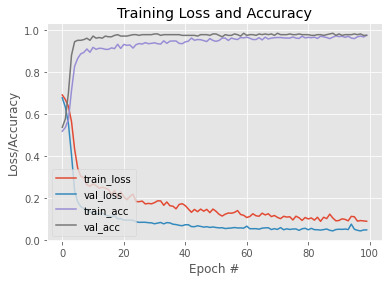

In [25]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("drive/My Drive/visualisation.png")
